# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from catboost import CatBoostRegressor

In [2]:
# load data
taxi = pd.read_csv('taxi.csv')
taxi

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [3]:
#check for duplicates
taxi.duplicated().sum()

0

In [4]:
#check for null values
taxi.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
#convert datetime column from object to datetime
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

#set datetime column as index
taxi.set_index('datetime',inplace=True)

# resample data by the hour
taxi = taxi.resample('1H').sum()


In [7]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


The taXI dataframe starts off with 26496 rows of data, once I converted the datetime column to datetime64 and resample the data based on hourly increments it condence the data frame to 4416 rows of data. No duplicates were found.

## Analysis

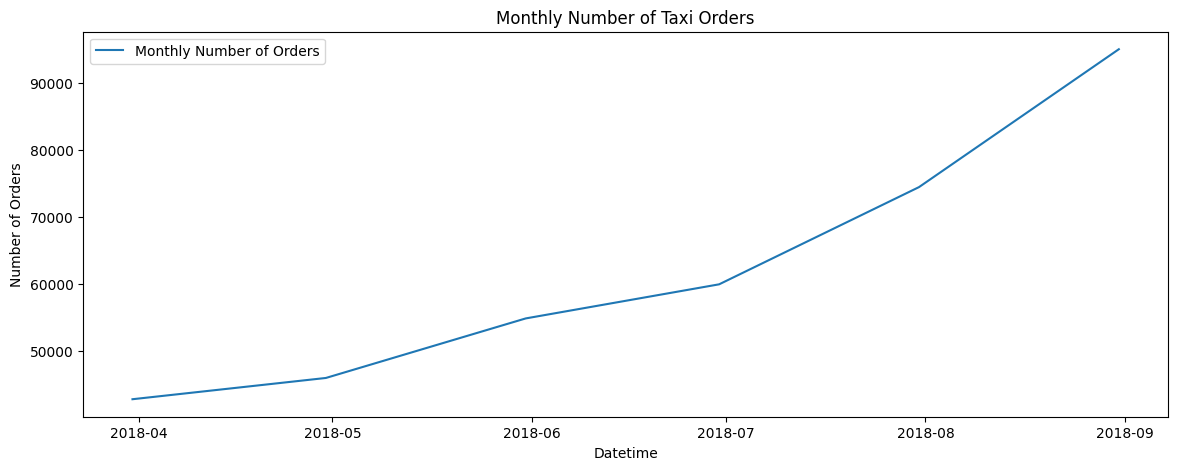

In [8]:
# Resample to monthly frequency
taxi_monthly = taxi.resample('M').sum()

plt.figure(figsize=(14, 5))
plt.plot(taxi_monthly.index, taxi_monthly['num_orders'], label='Monthly Number of Orders')
plt.title('Monthly Number of Taxi Orders')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()


The graph showcases a clear upward trend from April to September 2018 Growth accelerates in later months, showing it may continue to increase exponentialy from about 45,000 orders in April to over 90,000 in September  and beyond.

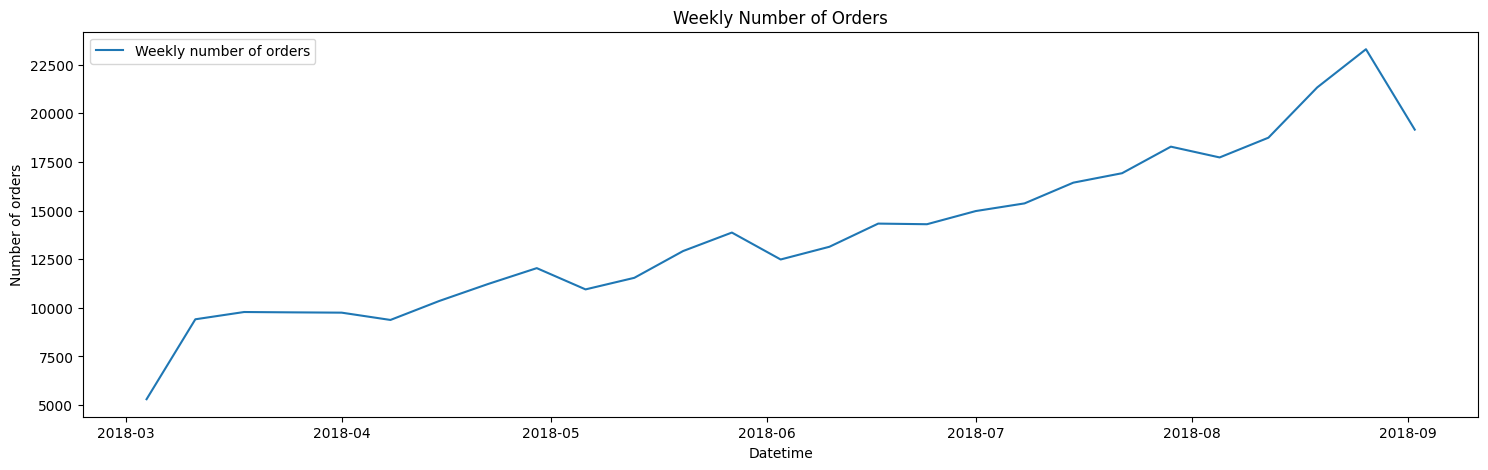

In [9]:
# resample by week
taxi_weekly = taxi.resample('1W').sum()

plt.figure(figsize=(18,5))
plt.plot(taxi_weekly.index, taxi_weekly['num_orders'], label='Weekly number of orders')
plt.title('Weekly Number of Orders')
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.legend()
plt.show()

Overall increasing trend from March to September 2018 Some week-to-week fluctuations, but generally consistent growth. Sharp increase in August, reaching peak of about 23,000 weekly orders. Going into september showed a spike drop, this drop from week to week seems to be the most drop from past weeks.

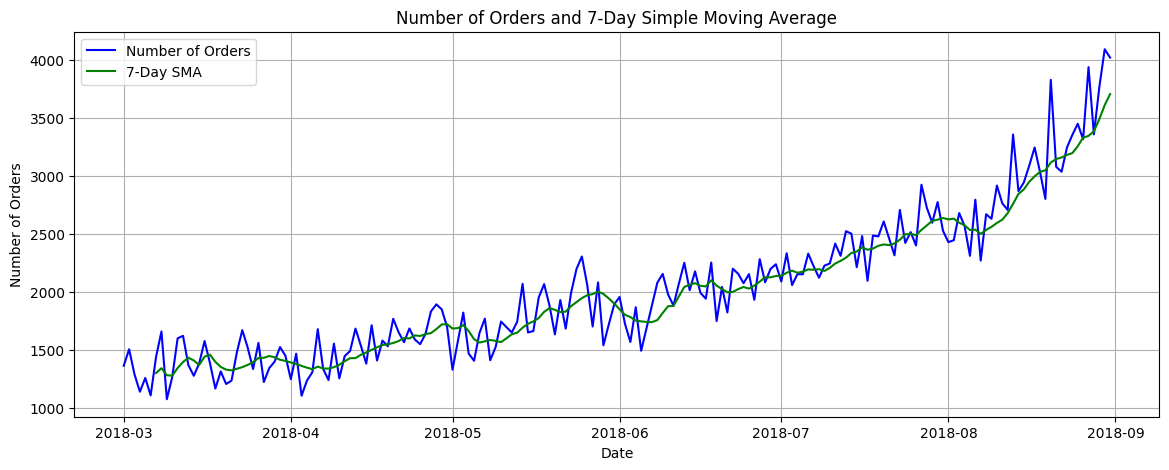

In [10]:
# resample by day
taxi_daily = taxi.resample('1D').sum()
taxi_daily['7-Day-SMA'] = taxi_daily['num_orders'].rolling(window=7).mean()

# Plotting the data
plt.figure(figsize=(14, 5))
plt.plot(taxi_daily['num_orders'], label='Number of Orders', color='blue')
plt.plot(taxi_daily['7-Day-SMA'], label='7-Day SMA', color='green')

# Adding title and labels
plt.title('Number of Orders and 7-Day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

upward trend from March to August 2018 Significant daily fluctuations, likely due to day-of-week effects Increasing amplitude of fluctuations over time Growth from about 1,500 daily orders in March to peaks over 4,000 in August

## Training

In [11]:

def make_features(data, max_lag):
    # Create datetime features
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # For each lag from 1 to max_lag, it creates a new feature lag_{lag} which contains the value of num_orders shifted back by lag time steps.
    # This allows the model to use previous values of num_orders as features for prediction.
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    # Drop rows with missing values
    data.dropna(inplace=True)

In [12]:
# adding rolling mean
taxi['rolling_mean'] = taxi.shift(1).rolling(12).mean()

# make features
make_features(taxi, 12)

In [13]:
taxi

,num_orders,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,30,57.083333,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 13:00:00,32,49.250000,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 14:00:00,48,44.833333,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 15:00:00,66,42.916667,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 16:00:00,43,42.916667,3,1,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,163.416667,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0
2018-08-31 20:00:00,154,170.916667,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0
2018-08-31 21:00:00,159,168.583333,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0


In [14]:
# feautures
features = taxi.drop(columns=['num_orders'])
target = taxi['num_orders']

# Perform train-test split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

In [15]:
features.head()

,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,57.083333,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 13:00:00,49.250000,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 14:00:00,44.833333,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 15:00:00,42.916667,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 16:00:00,42.916667,3,1,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


In [16]:
# the data seems sorted but just for good measure
taxi.sort_index(inplace=True)

# Check if the index is in chronological order
is_chronological = taxi.index.is_monotonic_increasing
print(f"Is the data in chronological order? {is_chronological}")

Is the data in chronological order? True


In [17]:
features

,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,57.083333,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 13:00:00,49.250000,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 14:00:00,44.833333,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 15:00:00,42.916667,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 16:00:00,42.916667,3,1,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,163.416667,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0
2018-08-31 20:00:00,170.916667,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0
2018-08-31 21:00:00,168.583333,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0


In [19]:
# Define the parameter grid
param_grid_lr = {
    'normalize': [True, False]
}

# Initialize Linear Regression
lr = LinearRegression()

# Setup GridSearchCV
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_lr.fit(features_train, target_train)

# Print best parameters and RMSE on training set
print("Best parameters found for Linear Regression:")
print(grid_search_lr.best_params_)
best_lr = grid_search_lr.best_estimator_
train_predict_lr = best_lr.predict(features_train)
rmse_lr_train = mean_squared_error(target_train, train_predict_lr, squared=False)
print(f"Linear Regression RMSE on Training Set: {rmse_lr_train:.2f}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END .....................................normalize=True; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
[CV] END ....................................normalize=False; total time=   0.0s
Best parameters found for Linear Regression:
{'normalize': True}
Linear Regression RMSE on Training Set: 30.09


In [20]:
# Define the parameter grid
param_grid_catboost = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'random_seed': [12345]
}

# Initialize CatBoost Regressor
catboost_reg = CatBoostRegressor()

# Setup GridSearchCV
grid_search_catboost = GridSearchCV(estimator=catboost_reg, param_grid=param_grid_catboost, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_catboost.fit(features_train, target_train)

# Print best parameters and RMSE on training set
print("Best parameters found for CatBoost:")
print(grid_search_catboost.best_params_)
best_catboost = grid_search_catboost.best_estimator_

# Calculate RMSE on training set
train_predict_catboost = best_catboost.predict(features_train)
rmse_catboost_train = mean_squared_error(target_train, train_predict_catboost, squared=False)
print(f"CatBoost RMSE on Training Set: {rmse_catboost_train:.2f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0:	learn: 28.7338800	total: 48ms	remaining: 4.75s
1:	learn: 28.1832297	total: 49.6ms	remaining: 2.43s
2:	learn: 27.5965731	total: 51ms	remaining: 1.65s
3:	learn: 27.0356184	total: 52.4ms	remaining: 1.26s
4:	learn: 26.5492984	total: 53.9ms	remaining: 1.02s
5:	learn: 26.0656854	total: 55.4ms	remaining: 867ms
6:	learn: 25.6151834	total: 56.8ms	remaining: 755ms
7:	learn: 25.1848101	total: 58.2ms	remaining: 670ms
8:	learn: 24.7491314	total: 59.7ms	remaining: 603ms
9:	learn: 24.3986186	total: 61.1ms	remaining: 550ms
10:	learn: 24.1275741	total: 62.6ms	remaining: 506ms
11:	learn: 23.7669737	total: 64.1ms	remaining: 470ms
12:	learn: 23.4303666	total: 65.5ms	remaining: 438ms
13:	learn: 23.0892517	total: 66.9ms	remaining: 411ms
14:	learn: 22.7395579	total: 68.4ms	remaining: 387ms
15:	learn: 22.4393406	total: 69.8ms	remaining: 367ms
16:	learn: 22.2107320	total: 71.2ms	remaining: 348ms
17:	learn: 21.9853908	total: 72.6ms	remaining: 331ms


[CV] END iterations=100, learning_rate=0.05, random_seed=12345; total time=   0.3s
0:	learn: 33.2638739	total: 2.59ms	remaining: 257ms
1:	learn: 32.5706332	total: 4.83ms	remaining: 237ms
2:	learn: 31.8746554	total: 6.95ms	remaining: 225ms
3:	learn: 31.2347964	total: 9.05ms	remaining: 217ms
4:	learn: 30.6687355	total: 11.2ms	remaining: 214ms
5:	learn: 30.2215227	total: 13.3ms	remaining: 208ms
6:	learn: 29.6915108	total: 15.3ms	remaining: 203ms
7:	learn: 29.2090352	total: 17.4ms	remaining: 200ms
8:	learn: 28.7653390	total: 19.4ms	remaining: 196ms
9:	learn: 28.3819359	total: 21.5ms	remaining: 193ms
10:	learn: 28.0217443	total: 23.5ms	remaining: 190ms
11:	learn: 27.6401126	total: 25.6ms	remaining: 188ms
12:	learn: 27.3341442	total: 27.6ms	remaining: 185ms
13:	learn: 26.9650456	total: 29.6ms	remaining: 182ms
14:	learn: 26.6481569	total: 31.7ms	remaining: 180ms
15:	learn: 26.3469220	total: 33.8ms	remaining: 177ms
16:	learn: 26.1214622	total: 35.8ms	remaining: 175ms
17:	learn: 25.8486716	tota

84:	learn: 13.2918997	total: 122ms	remaining: 21.6ms
85:	learn: 13.2373436	total: 124ms	remaining: 20.2ms
86:	learn: 13.1914365	total: 125ms	remaining: 18.7ms
87:	learn: 13.1015187	total: 127ms	remaining: 17.3ms
88:	learn: 13.0378823	total: 128ms	remaining: 15.8ms
89:	learn: 12.9788457	total: 129ms	remaining: 14.4ms
90:	learn: 12.8849708	total: 131ms	remaining: 12.9ms
91:	learn: 12.7974541	total: 132ms	remaining: 11.5ms
92:	learn: 12.7776835	total: 134ms	remaining: 10.1ms
93:	learn: 12.7230254	total: 135ms	remaining: 8.62ms
94:	learn: 12.6441966	total: 136ms	remaining: 7.18ms
95:	learn: 12.5711236	total: 138ms	remaining: 5.74ms
96:	learn: 12.5046419	total: 139ms	remaining: 4.31ms
97:	learn: 12.4606487	total: 141ms	remaining: 2.87ms
98:	learn: 12.3655276	total: 142ms	remaining: 1.44ms
99:	learn: 12.3133970	total: 144ms	remaining: 0us
[CV] END iterations=100, learning_rate=0.1, random_seed=12345; total time=   0.2s
0:	learn: 30.5746232	total: 2.15ms	remaining: 213ms
1:	learn: 29.3792119	

87:	learn: 18.0103062	total: 203ms	remaining: 27.6ms
88:	learn: 17.9634094	total: 205ms	remaining: 25.3ms
89:	learn: 17.8887612	total: 207ms	remaining: 23ms
90:	learn: 17.8427313	total: 209ms	remaining: 20.6ms
91:	learn: 17.8215324	total: 211ms	remaining: 18.3ms
92:	learn: 17.7827844	total: 213ms	remaining: 16ms
93:	learn: 17.7216800	total: 215ms	remaining: 13.7ms
94:	learn: 17.6982701	total: 217ms	remaining: 11.4ms
95:	learn: 17.6574079	total: 219ms	remaining: 9.12ms
96:	learn: 17.6242770	total: 221ms	remaining: 6.83ms
97:	learn: 17.5566915	total: 223ms	remaining: 4.55ms
98:	learn: 17.5027895	total: 225ms	remaining: 2.27ms
99:	learn: 17.4789670	total: 227ms	remaining: 0us
[CV] END iterations=100, learning_rate=0.1, random_seed=12345; total time=   0.3s
0:	learn: 28.7338800	total: 1.77ms	remaining: 353ms
1:	learn: 28.1832297	total: 3.23ms	remaining: 320ms
2:	learn: 27.5965731	total: 4.73ms	remaining: 311ms
3:	learn: 27.0356184	total: 6.15ms	remaining: 301ms
4:	learn: 26.5492984	total: 

[CV] END iterations=200, learning_rate=0.05, random_seed=12345; total time=   0.4s
0:	learn: 31.2490990	total: 2.14ms	remaining: 425ms
1:	learn: 30.6038785	total: 4.12ms	remaining: 407ms
2:	learn: 30.0966635	total: 6.1ms	remaining: 401ms
3:	learn: 29.4950178	total: 8.14ms	remaining: 399ms
4:	learn: 29.0833737	total: 9.95ms	remaining: 388ms
5:	learn: 28.6913664	total: 11.7ms	remaining: 379ms
6:	learn: 28.2008180	total: 13.6ms	remaining: 375ms
7:	learn: 27.7377933	total: 15.3ms	remaining: 368ms
8:	learn: 27.2885872	total: 17.1ms	remaining: 364ms
9:	learn: 26.9308068	total: 19ms	remaining: 360ms
10:	learn: 26.5693584	total: 20.7ms	remaining: 356ms
11:	learn: 26.1953976	total: 22.5ms	remaining: 353ms
12:	learn: 25.8938917	total: 24.3ms	remaining: 349ms
13:	learn: 25.6050382	total: 26ms	remaining: 346ms
14:	learn: 25.2889666	total: 27.8ms	remaining: 343ms
15:	learn: 25.0272189	total: 29.6ms	remaining: 341ms
16:	learn: 24.8027107	total: 31.4ms	remaining: 338ms
17:	learn: 24.6019417	total: 33

194:	learn: 15.7660823	total: 354ms	remaining: 9.07ms
195:	learn: 15.7342833	total: 356ms	remaining: 7.26ms
196:	learn: 15.7116730	total: 357ms	remaining: 5.44ms
197:	learn: 15.6980089	total: 359ms	remaining: 3.63ms
198:	learn: 15.6838320	total: 361ms	remaining: 1.81ms
199:	learn: 15.6617316	total: 363ms	remaining: 0us
[CV] END iterations=200, learning_rate=0.05, random_seed=12345; total time=   0.4s
0:	learn: 33.2638739	total: 2.24ms	remaining: 446ms
1:	learn: 32.5706332	total: 4.64ms	remaining: 459ms
2:	learn: 31.8746554	total: 6.91ms	remaining: 454ms
3:	learn: 31.2347964	total: 9.25ms	remaining: 453ms
4:	learn: 30.6687355	total: 11.6ms	remaining: 452ms
5:	learn: 30.2215227	total: 13.6ms	remaining: 440ms
6:	learn: 29.6915108	total: 15.7ms	remaining: 432ms
7:	learn: 29.2090352	total: 17.7ms	remaining: 426ms
8:	learn: 28.7653390	total: 19.8ms	remaining: 420ms
9:	learn: 28.3819359	total: 21.8ms	remaining: 414ms
10:	learn: 28.0217443	total: 23.8ms	remaining: 409ms
11:	learn: 27.6401126	t

186:	learn: 17.6715782	total: 398ms	remaining: 27.7ms
187:	learn: 17.6355559	total: 400ms	remaining: 25.6ms
188:	learn: 17.6075084	total: 402ms	remaining: 23.4ms
189:	learn: 17.5870270	total: 404ms	remaining: 21.3ms
190:	learn: 17.5620694	total: 406ms	remaining: 19.2ms
191:	learn: 17.5483136	total: 408ms	remaining: 17ms
192:	learn: 17.5307608	total: 410ms	remaining: 14.9ms
193:	learn: 17.5121530	total: 412ms	remaining: 12.8ms
194:	learn: 17.4965660	total: 414ms	remaining: 10.6ms
195:	learn: 17.4867825	total: 416ms	remaining: 8.49ms
196:	learn: 17.4657652	total: 418ms	remaining: 6.37ms
197:	learn: 17.4533972	total: 420ms	remaining: 4.24ms
198:	learn: 17.4402777	total: 422ms	remaining: 2.12ms
199:	learn: 17.4263986	total: 424ms	remaining: 0us
[CV] END iterations=200, learning_rate=0.05, random_seed=12345; total time=   0.5s
0:	learn: 28.2674583	total: 1.71ms	remaining: 341ms
1:	learn: 27.2331111	total: 3.13ms	remaining: 310ms
2:	learn: 26.1864149	total: 5.04ms	remaining: 331ms
3:	learn: 

196:	learn: 8.4186680	total: 292ms	remaining: 4.45ms
197:	learn: 8.3666091	total: 294ms	remaining: 2.97ms
198:	learn: 8.3453979	total: 295ms	remaining: 1.48ms
199:	learn: 8.3104087	total: 297ms	remaining: 0us
[CV] END iterations=200, learning_rate=0.1, random_seed=12345; total time=   0.4s
0:	learn: 30.5746232	total: 1.97ms	remaining: 392ms
1:	learn: 29.3792119	total: 3.86ms	remaining: 382ms
2:	learn: 28.4990824	total: 5.74ms	remaining: 377ms
3:	learn: 27.5030030	total: 7.55ms	remaining: 370ms
4:	learn: 26.8351409	total: 9.3ms	remaining: 363ms
5:	learn: 26.2690143	total: 11.1ms	remaining: 359ms
6:	learn: 25.5453900	total: 12.8ms	remaining: 354ms
7:	learn: 24.9252737	total: 14.6ms	remaining: 350ms
8:	learn: 24.3662535	total: 16.4ms	remaining: 347ms
9:	learn: 23.9326375	total: 18.2ms	remaining: 346ms
10:	learn: 23.5170150	total: 20ms	remaining: 343ms
11:	learn: 23.1257313	total: 21.8ms	remaining: 341ms
12:	learn: 22.8340785	total: 23.5ms	remaining: 338ms
13:	learn: 22.4446855	total: 25.3

171:	learn: 12.9787607	total: 315ms	remaining: 51.3ms
172:	learn: 12.9338670	total: 317ms	remaining: 49.5ms
173:	learn: 12.9326771	total: 319ms	remaining: 47.7ms
174:	learn: 12.9078517	total: 321ms	remaining: 45.8ms
175:	learn: 12.8703628	total: 323ms	remaining: 44ms
176:	learn: 12.8305862	total: 324ms	remaining: 42.1ms
177:	learn: 12.8195119	total: 326ms	remaining: 40.3ms
178:	learn: 12.7868121	total: 328ms	remaining: 38.4ms
179:	learn: 12.7783888	total: 329ms	remaining: 36.6ms
180:	learn: 12.7320907	total: 331ms	remaining: 34.8ms
181:	learn: 12.7087005	total: 333ms	remaining: 32.9ms
182:	learn: 12.6842253	total: 335ms	remaining: 31.1ms
183:	learn: 12.6503673	total: 336ms	remaining: 29.2ms
184:	learn: 12.6435556	total: 338ms	remaining: 27.4ms
185:	learn: 12.6028996	total: 344ms	remaining: 25.9ms
186:	learn: 12.5931684	total: 346ms	remaining: 24ms
187:	learn: 12.5620860	total: 347ms	remaining: 22.2ms
188:	learn: 12.5359913	total: 349ms	remaining: 20.3ms
189:	learn: 12.5066761	total: 35

133:	learn: 16.1701286	total: 271ms	remaining: 133ms
134:	learn: 16.1402195	total: 273ms	remaining: 131ms
135:	learn: 16.1161765	total: 275ms	remaining: 129ms
136:	learn: 16.1087941	total: 277ms	remaining: 127ms
137:	learn: 16.0972373	total: 279ms	remaining: 125ms
138:	learn: 16.0536514	total: 281ms	remaining: 123ms
139:	learn: 16.0241459	total: 283ms	remaining: 121ms
140:	learn: 15.9994375	total: 285ms	remaining: 119ms
141:	learn: 15.9696343	total: 287ms	remaining: 117ms
142:	learn: 15.9605371	total: 293ms	remaining: 117ms
143:	learn: 15.9204445	total: 295ms	remaining: 115ms
144:	learn: 15.8718233	total: 297ms	remaining: 113ms
145:	learn: 15.8313336	total: 299ms	remaining: 111ms
146:	learn: 15.8062194	total: 301ms	remaining: 108ms
147:	learn: 15.7812417	total: 303ms	remaining: 106ms
148:	learn: 15.7518909	total: 305ms	remaining: 104ms
149:	learn: 15.7181692	total: 307ms	remaining: 102ms
150:	learn: 15.7047782	total: 309ms	remaining: 100ms
151:	learn: 15.6755322	total: 311ms	remaining:

125:	learn: 18.8751778	total: 307ms	remaining: 181ms
126:	learn: 18.8724574	total: 310ms	remaining: 178ms
127:	learn: 18.8263543	total: 312ms	remaining: 176ms
128:	learn: 18.7758163	total: 314ms	remaining: 173ms
129:	learn: 18.7323798	total: 317ms	remaining: 171ms
130:	learn: 18.6967457	total: 319ms	remaining: 168ms
131:	learn: 18.6462780	total: 322ms	remaining: 166ms
132:	learn: 18.6056381	total: 324ms	remaining: 163ms
133:	learn: 18.5624667	total: 326ms	remaining: 161ms
134:	learn: 18.5575736	total: 329ms	remaining: 158ms
135:	learn: 18.5417823	total: 331ms	remaining: 156ms
136:	learn: 18.4971873	total: 333ms	remaining: 153ms
137:	learn: 18.4504207	total: 336ms	remaining: 151ms
138:	learn: 18.4148822	total: 338ms	remaining: 148ms
139:	learn: 18.3658342	total: 340ms	remaining: 146ms
140:	learn: 18.3122369	total: 343ms	remaining: 143ms
141:	learn: 18.2629841	total: 345ms	remaining: 141ms
142:	learn: 18.2339269	total: 347ms	remaining: 138ms
143:	learn: 18.2047489	total: 350ms	remaining:

## Testing

In [21]:
# Initialize Random Forest with best parameters
best_rf = RandomForestRegressor(max_depth=100, n_estimators=300, random_state=12345)

# Fit on the training data
best_rf.fit(features_train, target_train)

# Predict on the test set
predictions_rf = best_rf.predict(features_test)

# Calculate RMSE on test set
rmse_rf_test = mean_squared_error(target_test, predictions_rf, squared=False)
print(f"Random Forest RMSE on Test Set: {rmse_rf_test:.2f}")

Random Forest RMSE on Test Set: 43.17


In [22]:
# Initialize Linear Regression with best parameters
best_lr = LinearRegression(normalize=True)

# Fit on the training data
best_lr.fit(features_train, target_train)

# Predict on the test set
predictions_lr = best_lr.predict(features_test)

# Calculate RMSE on test set
rmse_lr_test = mean_squared_error(target_test, predictions_lr, squared=False)
print(f"Linear Regression RMSE on Test Set: {rmse_lr_test:.2f}")

Linear Regression RMSE on Test Set: 52.51


In [23]:
# Initialize CatBoost Regressor with best parameters
best_catboost = CatBoostRegressor(iterations=200, learning_rate=0.1, random_seed=12345)

# Fit on the training data
best_catboost.fit(features_train, target_train)

# Predict on the test set
predictions_catboost = best_catboost.predict(features_test)

# Calculate RMSE on test set
rmse_catboost_test = mean_squared_error(target_test, predictions_catboost, squared=False)
print(f"CatBoost RMSE on Test Set: {rmse_catboost_test:.2f}")

0:	learn: 36.9225288	total: 27ms	remaining: 5.37s
1:	learn: 35.4000053	total: 30.8ms	remaining: 3.05s
2:	learn: 33.9671182	total: 34.3ms	remaining: 2.25s
3:	learn: 32.7128618	total: 37.9ms	remaining: 1.85s
4:	learn: 31.6540181	total: 41.4ms	remaining: 1.61s
5:	learn: 30.6704506	total: 44ms	remaining: 1.42s
6:	learn: 29.9344962	total: 46.6ms	remaining: 1.28s
7:	learn: 29.4535408	total: 49.1ms	remaining: 1.18s
8:	learn: 28.9026555	total: 51.4ms	remaining: 1.09s
9:	learn: 28.2287037	total: 53.8ms	remaining: 1.02s
10:	learn: 27.7408367	total: 56.2ms	remaining: 966ms
11:	learn: 27.1745700	total: 58.7ms	remaining: 919ms
12:	learn: 26.8179035	total: 60.9ms	remaining: 877ms
13:	learn: 26.3312071	total: 63.3ms	remaining: 842ms
14:	learn: 25.9626298	total: 65.7ms	remaining: 810ms
15:	learn: 25.6298291	total: 68ms	remaining: 782ms
16:	learn: 25.3640336	total: 70.4ms	remaining: 757ms
17:	learn: 25.1350032	total: 72.7ms	remaining: 735ms
18:	learn: 24.8980463	total: 75.2ms	remaining: 716ms
19:	learn

192:	learn: 16.9862094	total: 526ms	remaining: 19.1ms
193:	learn: 16.9656455	total: 529ms	remaining: 16.3ms
194:	learn: 16.9443197	total: 531ms	remaining: 13.6ms
195:	learn: 16.9073458	total: 534ms	remaining: 10.9ms
196:	learn: 16.8871445	total: 536ms	remaining: 8.16ms
197:	learn: 16.8664372	total: 539ms	remaining: 5.44ms
198:	learn: 16.8519599	total: 541ms	remaining: 2.72ms
199:	learn: 16.8361149	total: 543ms	remaining: 0us
CatBoost RMSE on Test Set: 42.83


## Conclusion

Daily and Weekly Trends:

    Daily Orders: From March to August 2018, daily orders exhibit a general upward trend, increasing from around 1,500 in March to over 4,000 at their peak in August. However, significant fluctuations are observed, likely driven by day-of-week effects, which influence varying order volumes throughout the week.

    Weekly Orders: Weekly order data also demonstrates a steady upward trend between March and September 2018, despite occasional week-to-week variations. A sharp increase occurs in August, with weekly orders peaking at approximately 23,000. By the end of the period, a slight decline in weekly orders is evident.

Monthly Trends:

    Monthly Orders: The monthly data reveals a strong upward trajectory from April to September 2018, with growth accelerating in the later months. Orders surge from about 45,000 in April to over 90,000 in September, highlighting significant demand growth and an expanding service footprint during this time.
    
    
**Model Performance and Analysis:**

Model RMSE on Test Set:

    Random Forest: 43.17
    Linear Regression: 52.51
    CatBoost: 42.83
        The analysis highlights a clear upward trend in taxi orders across daily, weekly, and monthly metrics from 
        March to August 2018. Significant growth is observed, particularly in the later months, with August marking a 
        peak in order volumes.

    Among the machine learning models evaluated, CatBoost achieved the lowest RMSE of 42.83 on the test set, 
    demonstrating superior accuracy in forecasting demand. This performance makes CatBoost the most effective 
    model for predicting taxi orders in this context, outperforming Random Forest, and Linear Regression.
    